In [1]:
from compassV2 import *
import cirq
import stim
import stimcirq
import numpy as np
import pymatching as match
import matplotlib.pyplot as plt
import numpy as np

In [2]:
def bacon_shor_group(dimX, dimZ):
    """
    return the BS code stabilizers
    """
    Xs = []
    Zs = []
    for i in range(dimZ-1):
        s = list('_'*dimZ*dimX)
        for j in range(dimX):
            s[j*dimZ+i] = 'Z'
            s[j*dimZ+i+1] = 'Z'
        Zs.append(''.join(s))
    for i in range(dimX-1):
        s = list('_'*dimX*dimZ)
        for j in range(dimZ):
            s[j+i*dimZ] = 'X'
            s[j+(i+1)*dimZ] = 'X'
        Xs.append(''.join(s))
    return [Xs, Zs]

def bsgauge_group(dimX, dimZ):
    """
    return the gauge group generators for the BS code
    """
    Xs = []
    Zs = []
    # make X-type gauge ops
    for i in range(0, dimZ):
        for j in range(dimX-1):
            s = list('_'*dimX*dimZ)
            s[i+j*dimZ] = 'X'
            s[i+(j+1)*dimZ] = 'X'
            Xs.append(''.join(s))
    # make Z-type gauge ops
    for j in range(dimZ-1):
        for i in range(0, dimX): 
            s = list('_'*dimX*dimZ)
            s[i*dimZ+j] = 'Z'
            s[i*dimZ+j+1] = 'Z'
            Zs.append(''.join(s))
    return [Xs, Zs]

In [3]:
class Lattice2D():
    """
    convention: 
    X coords extend vertically |
    Z coords extend horizontally --
    store the coloring as a list with values in {-1, 0, 1}
    
    Red ~ -1
    Blue ~ +1
    White ~ 0
    
    preallocate logical X and L as cuts accross the lattice
    """
    def __init__(self, dimX, dimZ):
        self.dimX = dimX
        self.dimZ = dimZ
        self.colors = [0] * (dimX-1)*(dimZ-1)
        self.stabs = bacon_shor_group(dimX, dimZ)
        self.gauge = bsgauge_group(dimX, dimZ)
        self.Lx = ['X']*dimX+['_']*dimX*(dimZ-1)
        self.Lz = (['Z']+['_']*(dimX-1))*dimZ
        
    def size(self):
        return self.dimX*self.dimZ
        
    def __str__(self):
        vertex_rows = []
        face_rows = []
        dimX = self.dimX
        dimZ = self.dimZ
        for i in range(dimX):
            vertex_string = ''
            for j in range(dimZ):
                vertex_string += str(i*dimZ + j).zfill(3)
                if (j != dimZ-1):
                    vertex_string += '---'
            vertex_rows.append(vertex_string)
                
        for i in range(dimX-1):
            face_string = ''
            for j in range(dimZ-1):
                if(self.colors[i*(dimZ-1) + j] == -1):
                    face_string += ' | '+colored(' # ', 'red')
                elif(self.colors[i*(dimZ-1) + j] == +1):
                    face_string += ' | '+colored(' # ', 'blue')
                elif(self.colors[i*(dimZ-1) + j] == 0):
                    face_string += ' |    '
                else:
                    raise ValueError(f'Invalid color type {self.colors[i*dimZ+j]}')
                if j == dimZ-2:
                    face_string += ' |'
            face_rows.append(face_string)
        sout = ''
        for idx, row in enumerate(vertex_rows):
            sout += row +'\n'
            if idx != len(vertex_rows)-1:
                sout += face_rows[idx]+'\n'
        return sout
    
    def size(self):
        return self.dimX*self.dimZ
    
    def getG(self):
        return self.gauge[0]+self.gauge[1]
    
    def getGx(self):
        return self.gauge[0]
    
    def getGz(self):
        return self.gauge[1]
    
    def getS(self):
        return self.stabs[0]+self.stabs[1]
    
    def getSx(self):
        return self.stabs[0]
    
    def getSz(self):
        return self.stabs[1]
    
    def getDims(self):
        return (self.dimX, self.dimZ)
    
    def max_stab_number(self):
        return self.dimX*self.dimZ - 1
    
    def display(self, pauli):
        dimX = self.dimX
        dimZ = self.dimZ
        if (len(pauli) != dimX*dimZ):
            raise ValueError("Pauli string dimension mismatch with lattice size")
        sout = ''
        slist = list(pauli)
        for i in range(dimX):
            for j in range(dimZ):
                if slist[i*dimZ+j] == 'X':
                    sout += ' X '
                elif slist[i*dimZ+j] == 'Z':
                    sout += ' Z '
                else:
                    sout += '   '
                if (j != dimZ-1):
                    sout += '---'
            if (i != dimX -1):
                sout += '\n'
                sout += ' |    '*dimZ
            sout += '\n'
        print(sout)
        
    def color_lattice(self, colors):
        """
        replace color state with input and recalculate stab and gauge groups 
        """
        dimX = self.dimX-1
        dimZ = self.dimZ-1
        if(len(colors) != dimX*dimZ):
            raise ValueError("Color dimension mismatch with lattice size")
        
        self.stabs = bacon_shor_group(self.dimX, self.dimZ)
        self.gauge = bsgauge_group(self.dimX, self.dimZ)
        self.colors = colors
        
        
        for cidx, c in enumerate(colors):
            if c == -1:
                self.update_groups((int(np.floor(cidx/dimZ)), cidx%dimZ), -1)
            elif c == +1:
                self.update_groups((int(np.floor(cidx/dimZ)), cidx%dimZ), +1)
        
        
    def update_groups(self, coords, cut_type):
        """
        cut the stabilizer group by coloring the face with the given type
            AND
        update the gauge group 
    
        algo: 
        [0] pick the gauge operator g to cut around
        [1] find s \in S that has weight-2 overlap with g
        [2] divide that s 
        [3] update the gauge group 
        """
        (i, j) = coords
        dimX = self.dimX
        dimZ = self.dimZ
        [Sx, Sz] = self.getSx(), self.getSz()
        [Gx, Gz] = self.getGx(), self.getGz()
        
        if cut_type == -1:
            # -1 = red which is a Z-cut
            g = ['_'] * dimX*dimZ
            g[i*dimZ + j] = 'Z'
            g[i*dimZ + j + 1] = 'Z'
            
            gvec = pauli2vector(''.join(g))
            
            # cut the relevant stabilizer
            for idx, s in enumerate(Sz):
                # find the overlapping stabilizer
                if pauli_weight(np.bitwise_xor(gvec, pauli2vector(s))) == pauli_weight(s) - 2:
                    # cut s into two vertical parts 
                    s1 = ['_'] * dimX*dimZ
                    s2 = ['_'] * dimX*dimZ
                    for k in range(0, i+1):
                        s1[k*dimZ + j] = s[k*dimZ + j]
                        s1[k*dimZ + j+1] = s[k*dimZ + j+1]
                    for k in range(i+1, dimX):
                        s2[k*dimZ + j] = s[k*dimZ + j]
                        s2[k*dimZ + j+1] = s[k*dimZ + j+1]
                    del Sz[idx]
                    Sz.append(''.join(s1))
                    Sz.append(''.join(s2))
                    break
            
            # make new gauge operator and update gauge group 
            gauge = ['_'] * dimX*dimZ
            for k in range(0, j+1):
                gauge[i + k*dimZ] = 'Z'
                gauge[i + k*dimZ + 1] = 'Z'
            Gx_new = []
            for g in Gx:
                if twisted_product(pauli2vector(''.join(g)), pauli2vector(''.join(gauge))) == 0:
                    Gx_new.append(g)
            Gx = Gx_new
                
        elif cut_type == +1:
            # +1 = blue that is a X-cut:
            g = ['_'] * dimX*dimZ
            g[i*dimZ + j] = 'X'
            g[(i+1)*dimZ + j ] = 'X'
            
            gvec = pauli2vector(''.join(g))
            
            # cut the relevant stabilizer
            for idx, s in enumerate(Sx):
                # find the overlapping stabilizer
                if pauli_weight(np.bitwise_xor(gvec, pauli2vector(s))) == pauli_weight(s) - 2:
                    # cut s into two horizontal parts 
                    s1 = ['_'] * dimX*dimZ
                    s2 = ['_'] * dimX*dimZ
                    for k in range(0, j+1):
                        s1[i*dimZ + k] = s[i*dimZ + k]
                        s1[(i+1)*dimZ + k] = s[(i+1)*dimZ + k]
                    for k in range(j+1, dimX):
                        s2[i*dimZ + k] = s[i*dimZ + k]
                        s2[(i+1)*dimZ + k] = s[(i+1)*dimZ + k]
                    del Sx[idx]
                    Sx.append(''.join(s1))
                    Sx.append(''.join(s2))
                    break
            
            # make new gauge operator and update gauge group 
            gauge = ['_'] * dimX*dimZ
            for k in range(0, j+1):
                gauge[k + i*dimZ] = 'X'
                gauge[k + (i+1)*dimZ] = 'X'
            Gz_new = []
            for g in Gz:
                if twisted_product(pauli2vector(''.join(g)), pauli2vector(''.join(gauge))) == 0:
                    Gz_new.append(g)
            Gz = Gz_new

        # update the groups
        self.stabs = [Sx, Sz]
        self.gauge = [Gx, Gz]
        

In [31]:
from typing import Dict, List, Tuple

def _build_by_code(mat: np.ndarray) -> List[str]:
    """Transforms a matrix of Booleans into a list of Pauli strings.
    Takes into input a matrix of Boolean interpreted as row-vectors, each having dimension 2 * n.
    The matrix is converted into another matrix with as many rows, but this time the vectors
    contain the letters I, X, Y, and Z representing Pauli operators.
    Args:
        mat: The input matrix of Booleans.
    Returns:
        A list of Pauli strings.
    """
    out = []
    n = mat.shape[1] // 2
    for i in range(mat.shape[0]):
        ps = ''
        for j in range(n):
            k = 2 * mat[i, j + n] + mat[i, j]
            ps += "IXZY"[k]
        out.append(ps)
    return out


# It was considered to use scipy.linalg.lu but it seems to be only for real numbers and does
# not allow to restrict only on a section of the matrix.
def _gaussian_elimination(
    M: np.ndarray, min_row: int, max_row: int, min_col: int, max_col: int, permutation: list
) -> int:
    """Gaussian elimination for standard form.
    Performs a Gaussian elemination of the input matrix and transforms it into its reduced row
    echelon form. The elimination is done only on a sub-section of the matrix (specified) by
    ranges of rows and columns. The matrix elements are integers {0, 1} interpreted as elements
    of GF(2).
    In short, this is the implementation of section 4.1 of the thesis.
    Args:
        M: The input/output matrix
        min_row: The minimum row (inclusive) where the perform the elimination.
        max_row: The maximum row (exclusive) where the perform the elimination.
        min_col: The minimum column (inclusive) where the perform the elimination.
        max_col: The maximum column (exclusive) where the perform the elimination.
    Returns:
        The rank of the matrix.
    """
    assert M.shape[1] % 2 == 0
    n = M.shape[1] // 2

    max_rank = min(max_row - min_row, max_col - min_col)

    rank = 0
    for r in range(max_rank):
        
        i = min_row + r
        j = min_col + r
        
        pivot_rows, pivot_cols = np.nonzero(M[i:max_row, j:max_col])

        if pivot_rows.size == 0:
            break

        pi = pivot_rows[0]
        pj = pivot_cols[0]
        print(min_row, j, pj)

        # Swap the rows:
        M[[i, i + pi]] = M[[i + pi, i]]

        # Swap the columns:
        M[:, [(j + pj), j]] = M[:, [j, (j + pj)]]
        if j > n: 
            # if you're in the 2nd column space
            j_other_half = (j + n) % (2 * n)
            permutation[permutation.index(j_other_half + pj)], permutation[permutation.index(j_other_half)] = permutation[permutation.index(j_other_half)], permutation[permutation.index(j_other_half + pj)]
        else:
            permutation[permutation.index(j + pj)], permutation[permutation.index(j)] = permutation[permutation.index(j)], permutation[permutation.index(j + pj)]

        # Since the columns in the left and right half of the matrix represent the same qubit, we
        # also need to swap the corresponding column in the other half.
        j_other_half = (j + n) % (2 * n)
        M[:, [(j_other_half + pj), j_other_half]] = M[:, [j_other_half, (j_other_half + pj)]]

        # Do the elimination.
        for k in range(i + 1, max_row):
            if M[k, j] == 1:
                M[k, :] = np.mod(M[i, :] + M[k, :], 2)

        rank += 1

    # Backward replacing to get identity
    for r in reversed(range(rank)):
        i = min_row + r
        j = min_col + r

        # Do the elimination in reverse.
        for k in range(i - 1, min_row - 1, -1):
            if M[k, j] == 1:
                M[k, :] = np.mod(M[i, :] + M[k, :], 2)

    return rank


def _transfer_to_standard_form(
    M: np.array, n: int, k: int
) -> Tuple[np.array, np.array, np.array, int]:
    """Puts the stabilizer matrix in its standardized form, as in section 4.1 of the thesis.
    Args:
        M: The stabilizier matrix, to be standardized.
        n: Dimension of the code words.
        k: Dimension of the message words.
    Returns:
        The standardized matrix.
        The logical Xs.
        The logical Zs.
        The rank of the matrix.
        
    Keeps track of the permutation of columns in gaussian elimination 
    
    """
    permutation = [i for i in range(n)]

    # Performing the Gaussian elimination as in section 4.1
    print('initial: ', permutation)
    r: int = _gaussian_elimination(M, 0, n - k, 0, n, permutation)
    print('after 1st elim: ', permutation)
    _ = _gaussian_elimination(M, r, n - k, n + r, 2 * n, permutation)
    print('after 2nd elim: ', permutation)
    
    # Get matrix sub-components, as per equation 4.3:
    A2 = M[0:r, (n - k) : n]
    C1 = M[0:r, (n + r) : (2 * n - k)]
    C2 = M[0:r, (2 * n - k) : (2 * n)]
    E = M[r : (n - k), (2 * n - k) : (2 * n)]

    X = np.concatenate(
        [
            np.zeros((k, r), dtype=np.int8),
            E.T,
            np.eye(k, dtype=np.int8),
            np.mod(E.T @ C1.T + C2.T, 2),
            np.zeros((k, n - r), np.int8),
        ],
        axis=1,
    )

    Z = np.concatenate(
        [
            np.zeros((k, n), dtype=np.int8),
            A2.T,
            np.zeros((k, n - k - r), dtype=np.int8),
            np.eye(k, dtype=np.int8),
        ],
        axis=1,
    )
    return M, X, Z, r, permutation


class StabilizerCode(object):
    def __init__(self, group_generators: List[str], correctable_errors: List[str]):
        n = len(group_generators[0])
        k = n - len(group_generators)

        # Build the matrix defined in section 3.4. Each row corresponds to one generator of the
        # code, which is a vector of dimension n. The elements of the vectors are Pauli matrices
        # encoded as I, X, Y, or Z. However, as described in the thesis, we encode the Pauli
        # vector of 2*n Booleans.
        M = np.zeros((n - k, 2 * n), np.int8)
        for i, group_generator in enumerate(group_generators):
            for j, c in enumerate(group_generator):
                if c == 'X' or c == 'Y':
                    M[i, j] = 1
                elif c == 'Z' or c == 'Y':
                    M[i, n + j] = 1

        M, X, Z, r, permutation = _transfer_to_standard_form(M, n, k)

        self.n: int = n
        self.k: int = k
        self.r: int = r
        self.M: List[str] = _build_by_code(M)
        self.logical_Xs: List[str] = _build_by_code(X)
        self.logical_Zs: List[str] = _build_by_code(Z)
        self.permutation = permutation # register permutation mapping physical qubit indices to encoded indices

        self.syndromes_to_corrections: Dict[Tuple[int, ...], Tuple[str, int]] = {}

        for qid in range(self.n):
            for op in correctable_errors:
                syndrome = tuple(
                    1 if self.M[r][qid] == 'I' or self.M[r][qid] == op else -1
                    for r in range(self.n - self.k)
                )
                self.syndromes_to_corrections[syndrome] = (op, qid)
                

                
    def encoding_circuit(self):
        """
        produces an encoding circuit that maps the all 0's register to logical 0

            
        Returns: 
            A circuit that maps the register to the logical 0 state
            
        tracks permutations of columns when reducing to standard form 
        
        JPM
        """
        register = [cirq.NamedQubit(str(i)) for i in range(self.n)]
        gate_dict = {'X': cirq.X, 'Y': cirq.Y, 'Z': cirq.Z}
        
        circuit = cirq.Circuit()
        
        for r in range(self.r):
            physical_r = self.permutation.index(r)
            circuit.append(cirq.H(register[physical_r]))

            # Let's consider the first stabilizer:
            # The reason for adding S gate is Y gate we used is the complex format (i.e. to
            # make it Hermitian). It has following four cases: (ignore the phase factor)
            # (I+X@P_2...P_k)|0...0> = |0...0> + |1>|\psi>
            # (I+Y@P_2...P_k)|0...0> = |0...0> + i|1>|\psi>
            # The other forms are not possible in the standard form, by construction.

            # The first case means we need [1,1] vector and controlled gates and in the
            # second case we need [1, i] vector and controlled gates. Corresponding, it is
            # the first column of H and the first column of SH respectively.

            # For the other stabilizers, the process can be repeated, as by definition they
            # commute.

            if self.M[r][r] == 'Y' or self.M[r][r] == 'Z':
                circuit.append(cirq.S(register[physical_r]))

            for n in range(self.n):
                physical_n = self.permutation.index(n)
                if n == r:
                    continue
                if self.M[r][n] == 'I':
                    continue
                op = gate_dict[self.M[r][n]]
                assert op == cirq.X
                circuit.append(cirq.CNOT(register[physical_r], register[physical_n]))

        return circuit
    
    
    def encode(
        self, additional_qubits: List[cirq.Qid], unencoded_qubits: List[cirq.Qid]
    ) -> cirq.Circuit:
        """Creates a circuit that encodes the qubits using the code words.
        Args:
            additional_qubits: The list of self.n - self.k qubits needed to encode the qubit.
            unencoded_qubits: The list of self.k qubits that contain the original message.
        Returns:
            A circuit where the self.n qubits are the encoded qubits.
            
        """
        assert len(additional_qubits) == self.n - self.k
        assert len(unencoded_qubits) == self.k
        qubits = additional_qubits + unencoded_qubits

        circuit = cirq.Circuit()

        # Equation 4.8:
        # This follows the improvements of:
        # https://cs269q.stanford.edu/projects2019/stabilizer_code_report_Y.pdf
        for r, x in enumerate(self.logical_Xs):
            for j in range(self.r, self.n - self.k):
                # By constructions, the first r rows can never contain a Z, as
                # r is defined by the Gaussian elimination as the rank.
                if x[j] == 'X' or x[j] == 'Y':
                    circuit.append(
                        cirq.CNOT(
                            unencoded_qubits[r], additional_qubits[j]
                        )
                    )

        gate_dict = {'X': cirq.X, 'Y': cirq.Y, 'Z': cirq.Z}

        for r in range(self.r):
            circuit.append(cirq.H(qubits[r]))

            # Let's consider the first stabilizer:
            # The reason for adding S gate is Y gate we used is the complex format (i.e. to
            # make it Hermitian). It has following four cases: (ignore the phase factor)
            # (I+X@P_2...P_k)|0...0> = |0...0> + |1>|\psi>
            # (I+Y@P_2...P_k)|0...0> = |0...0> + i|1>|\psi>
            # The other forms are not possible in the standard form, by construction.

            # The first case means we need [1,1] vector and controlled gates and in the
            # second case we need [1, i] vector and controlled gates. Corresponding, it is
            # the first column of H and the first column of SH respectively.

            # For the other stabilizers, the process can be repeated, as by definition they
            # commute.

            if self.M[r][r] == 'Y' or self.M[r][r] == 'Z':
                circuit.append(cirq.S(qubits[r]))

            for n in range(self.n):
                if n == r:
                    continue
                if self.M[r][n] == 'I':
                    continue
                op = gate_dict[self.M[r][n]]
                assert op == cirq.X
                circuit.append(cirq.CNOT(qubits[r], qubits[n]))
                # circuit.append(cirq.ControlledOperation([qubits[r]], op(qubits[n])))
        # At this stage, the state vector should be equal to equations 3.17 and 3.18.

        return circuit

    def correct(self, qubits: List[cirq.Qid], ancillas: List[cirq.Qid]) -> cirq.Circuit:
        """Corrects the code word.
        Creates a correction circuit by computing the syndrome on the ancillas, and then using this
        syndrome to correct the qubits.
        Args:
            qubits: a vector of self.n qubits that contains (potentially corrupted) code words
            ancillas: a vector of self.n - self.k qubits that are set to zero and will contain the
                syndrome once the circuit is applied.
        Returns:
            The circuit that both computes the syndrome and uses this syndrome to correct errors.
        """
        circuit = cirq.Circuit()

        gate_dict = {'X': cirq.X, 'Y': cirq.Y, 'Z': cirq.Z}

        # We set the ancillas so that measuring them directly would be the same
        # as measuring the qubits with Pauli strings. In other words, we store
        # the syndrome inside the ancillas.
        for r in range(self.n - self.k):
            for n in range(self.n):
                if self.M[r][n] == 'Z':
                    circuit.append(cirq.CNOT([qubits[n]], ancillas[r]))
                elif self.M[r][n] == 'X':
                    circuit.append(cirq.H(qubits[n]))
                    circuit.append(cirq.CNOT([qubits[n]], ancillas[r]))
                    circuit.append(cirq.H(qubits[n]))
                elif self.M[r][n] == 'Y':
                    circuit.append(cirq.S(qubits[n]) ** -1)
                    circuit.append(cirq.H(qubits[n]))
                    circuit.append(cirq.CNOT([qubits[n]], ancillas[r]))
                    circuit.append(cirq.H(qubits[n]))
                    circuit.append(cirq.S(qubits[n]))

        # At this stage, the ancillas are equal to the syndrome. Now, we apply
        # the errors back to correct the code.

        for syndrome, correction in self.syndromes_to_corrections.items():
            op = gate_dict[correction[0]]
            n = correction[1]

            # We do a Boolean operation on the ancillas (i.e. syndrome).
            for r in range(self.n - self.k):
                if syndrome[r] == 1:
                    circuit.append(cirq.X(ancillas[r]))

            circuit.append(cirq.ControlledOperation(ancillas, op(qubits[n])))

            for r in range(self.n - self.k):
                if syndrome[r] == 1:
                    circuit.append(cirq.X(ancillas[r]))

        return circuit

    def decode(self, qubits: List[cirq.Qid], ancillas: List[cirq.Qid], state_vector) -> List[int]:
        """Computes the output of the circuit by projecting onto the \bar{Z}.
        Args:
            qubits: the qubits where the (now corrected) code words are stored.
            ancillas: the qubits where the syndrome is stored
            state_vector: a vector containing the state of the entire circuit
        Returns:
            The decoded and measured code words.
        """
        qubit_map = {qubit: i for i, qubit in enumerate(qubits + ancillas)}

        decoded = []
        for z in self.logical_Zs:
            pauli_string: cirq.PauliString = cirq.PauliString(dict(zip(qubits, z)))
            trace = pauli_string.expectation_from_state_vector(state_vector, qubit_map)
            decoded.append(round((1 - trace.real) / 2))
        return decoded

# A single perfect compass circuit

plan: 
1) Each stabilizer gets an ancilla qubit -- make a dictionary map between stabs and ancilla indices

In [5]:
def encoder_from_lattice(lattice):
    """
    make a stim circuit encoder supported on the lattice's register
    """
    stabs = lattice.getS()
    num_logicals = lattice.size() - len(stabs) # includes gauge DOF
    qbits = [cirq.NamedQubit(str(i)) for i in range(lattice.size())]
    code = StabilizerCode(stabs, [])
    ecirc_cirq = code.encoding_circuit()
    ecirc = stimcirq.cirq_circuit_to_stim_circuit(ecirc_cirq)
    return ecirc

In [6]:
class CompassCircuitGenerator():
    """
    A compass circuit generator object
        contains functions that generate circuits from compass lattices
        
    Can use this class to setup circuit constructions for:
    1) single shot perfect measurement trials for circuit noise distribution
    2) multi shot imperfect measurement trials for circuit noise distributions 
    3) (future) circuits that model time-fluctuating noise
    """
    
    def __init__(self):
        pass
    
    def biased_pauli_perfmeas(self, lattice, erate, bias):
        """
        uses a fixed universal biased Pauli error rate  
        the circuit contains only one error, sampled from a Pauli channel
        returns a perfect measurement circuit for given error rates
        
        same error model as in "2D Compass Codes"
        
        p = px + py + pz <-- erate
        n = pz/(px + py) <-- bias
        
        px + py = pz/n
        p = (1+1/n)pz
        pz = n*p/(1+n)
        px = py = (p - pz)/2
        """
        # [0] calculate error rates
        pz = bias*erate/(1+bias)
        px = (erate - pz)/2
        py = px
        print(px, py, pz)
        
        # [1] make encoding circuit
        circ = encoder_from_lattice(lattice)
        print(stimcirq.stim_circuit_to_cirq_circuit(circ))
        
        # [2] measure logical Z
        
        # [3] inject an error channel
        echan = stim.Circuit(f"PAULI_CHANNEL_1({px}, {py}, {pz})")
        circ = circ + echan
        
        # [4] append gadgets
        gadgets = lattice_to_gadgets(lattice, 'hadamard')
        for g in gadgets:
            circ = circ + g
        
        # [5] measure syndromes
        circ.append_operation("M", [lattice.size()+i for i in range(len(lattice.getS()))])
        
        return circ
        
    
        

In [7]:
def make_ancilla_map(stab_list):
    ancilla_map = dict()
    for idx, s in enumerate(stab_list):
        ancilla_map[idx] = s
    return ancilla_map

def lattice_to_gadgets(lattice, construction='direct'):
    """
    takes a list of stabilizers
    outputs a list of measurement gadgets
    
    two types of constructions:
        1) direct using only controlled X and Z gates from data to ancilla
        2) haddamard using H gates on ancilla and controlled gates from ancilla to data
    
    
    register support of the output circuit is
        first N=dimX*dimZ qbits as data qubits
        last N-1 qbits as ancilla qubits
        
        if there's gauge d.o.f., then there's unused ancilla bits
    """
    N = lattice.dimX*lattice.dimZ
    gadgets = []
    ancilla_map = make_ancilla_map(lattice.getS())
    
    if construction == 'direct':
        for ancilla in ancilla_map.keys():
            circ = stim.Circuit()
            stab = ancilla_map[ancilla]
            for idx, pauli in enumerate(stab):
                if pauli == 'X':
                    circ.append('CZ', [idx, ancilla+N])
                elif pauli == 'Z':
                    circ.append('CX', [idx, ancilla+N])
                elif pauli == 'Y':
                    raise ValueError('Y-type stab not supported')
            gadgets.append(circ)
    
    elif construction == 'hadamard':
        for ancilla in ancilla_map.keys():
            circ = stim.Circuit()
            stab = ancilla_map[ancilla]
            circ.append('H', ancilla+N)
            for idx, pauli in enumerate(stab):
                if pauli == 'X':
                    circ.append('CX', [ancilla+N, idx])
                elif pauli == 'Z':
                    circ.append('CZ', [ancilla+N, idx])
                elif pauli == 'Y':
                    raise ValueError('Y-type stab not supported')
            circ.append('H', ancilla+N)
            gadgets.append(circ)
    return gadgets

In [79]:
lat = Lattice2D(4, 4)
lat.color_lattice([-0, 0, 0, 0, 0, 0, 0, 0, 0])
print(lat, lat.max_stab_number())
print((lat.getS()))

000---001---002---003
 |     |     |     |
004---005---006---007
 |     |     |     |
008---009---010---011
 |     |     |     |
012---013---014---015
 15
['XXXXXXXX________', '____XXXXXXXX____', '________XXXXXXXX', 'ZZ__ZZ__ZZ__ZZ__', '_ZZ__ZZ__ZZ__ZZ_', '__ZZ__ZZ__ZZ__ZZ']


In [80]:
# gadgets = lattice_to_gadgets(lat)
# for idx, g in enumerate(gadgets):
#     print(stimcirq.stim_circuit_to_cirq_circuit(g), '\n', lat.getS()[idx])

In [81]:
gen = CompassCircuitGenerator()
print(lat.getS())
circ = gen.biased_pauli_perfmeas(lat, 0.4, 1)

['XXXXXXXX________', '____XXXXXXXX____', '________XXXXXXXX', 'ZZ__ZZ__ZZ__ZZ__', '_ZZ__ZZ__ZZ__ZZ_', '__ZZ__ZZ__ZZ__ZZ']
0.1 0.1 0.2
initial:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
0 0 0
0 1 3
0 2 6
after 1st elim:  [0, 4, 8, 3, 1, 5, 6, 7, 2, 9, 10, 11, 12, 13, 14, 15]
3 19 1
3 20 2
3 21 1
after 2nd elim:  [0, 6, 8, 3, 1, 5, 4, 7, 2, 9, 10, 11, 12, 13, 14, 15]
               ┌──┐           ┌──┐   ┌───┐   ┌───┐   ┌──┐
0: ────H───@────@─────@───@────@──────@───────@─────────────────
           │    │     │   │    │      │       │
1: ────────┼────┼X────┼───┼────┼──────┼───────┼─────────────────
           │    ││    │   │    │      │       │
2: ────────┼────┼┼────X───┼────┼──────┼───────┼─────────────────
           │    ││        │    │      │       │
3: ────────X────┼┼────────┼────┼──────┼───────┼─────────────────
                ││        │    │      │       │
4: ────H───@────┼@────@───┼────┼@─────┼@──────┼@──────@─────────
           │    │     │   │    ││     ││    

In [86]:
sampler = circ.compile_sampler()
print(sampler.sample(shots=10))

[[0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 1 0 0 0 0]
 [0 1 0 0 0 0]
 [0 1 0 0 0 0]
 [0 1 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 1 0 0 0 0]
 [0 1 0 0 0 0]]


In [54]:
for i in range(9):
    for c in [-1, 0, 1]:
        

SyntaxError: incomplete input (2465238156.py, line 3)

In [28]:
print(lat.getS())

['XXXXXX___', '___X__X__', '____X__X_', '_____X__X', 'ZZ_______', '___ZZ_ZZ_', '_ZZ______', '____ZZ_ZZ']


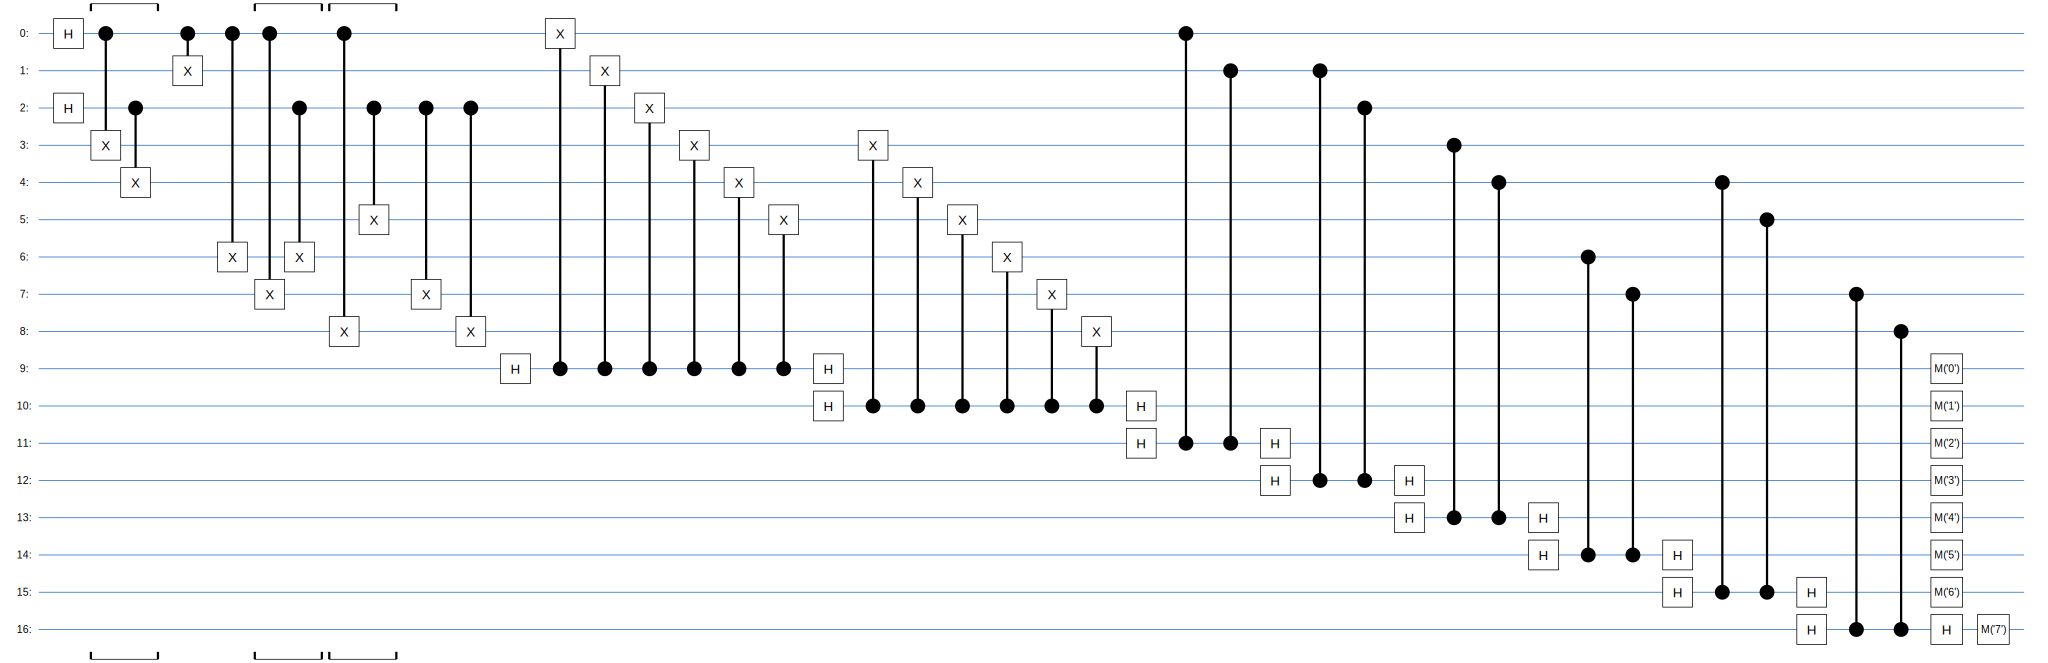

In [268]:
from cirq.contrib.svg import SVGCircuit
SVGCircuit(stimcirq.stim_circuit_to_cirq_circuit(circ))

In [56]:
qubits?

Object `qubits` not found.
